# Imports

In [1]:
import mat73
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyampd.ampd import find_peaks, find_peaks_original, find_peaks_adaptive
import scipy
from IPython.display import display, HTML
from tqdm import tqdm
import pickle
import mrmr
import json
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
data = mat73.loadmat("dataset/VitalDB_AAMI_Test_Subset.mat")
data["Subset"]["Signals"] = [np.array(array) for array in data["Subset"]["Signals"]]
data_df = pd.DataFrame(data["Subset"])

In [3]:
data_df

,Age,BMI,DBP,Gender,Height,SBP,Signals,Subject,Weight
0,26.0,26.3,57.966649,[M],183.9,99.987120,"[[0.36403973055607636, 0.3798729789472614, 0.4...",[p000238_1],89.05
1,26.0,26.3,58.320482,[M],183.9,100.759058,"[[0.29321360098768473, 0.2860885144086844, 0.2...",[p000238_1],89.05
2,26.0,26.3,59.022303,[M],183.9,102.019124,"[[0.3234821974411744, 0.32359610215460555, 0.3...",[p000238_1],89.05
3,26.0,26.3,59.802165,[M],183.9,102.834648,"[[0.6553748906811834, 0.667645292549456, 0.684...",[p000238_1],89.05
4,26.0,26.3,58.068798,[M],183.9,100.265742,"[[0.30340272774572963, 0.3021664670400199, 0.3...",[p000238_1],89.05
...,...,...,...,...,...,...,...,...,...
661,51.0,23.6,67.354875,[M],186.0,158.041383,"[[0.16495809222382543, 0.15759405428417678, 0....",[p006055_1],81.60
662,51.0,23.6,66.764646,[M],186.0,154.649431,"[[0.44585714955877265, 0.4531576496332196, 0.4...",[p006055_1],81.60
663,51.0,23.6,67.429088,[M],186.0,160.446045,"[[0.33331191534757354, 0.29681460869229337, 0....",[p006055_1],81.60
664,51.0,23.6,69.336335,[M],186.0,165.430557,"[[0.6019641669273851, 0.6013251725554011, 0.59...",[p006055_1],81.60


In [4]:
data_df["Gender"] = data_df["Gender"].astype("str").replace(["['M']", "['F']"], [1, 0]).astype("category")

## Visualization of Signals

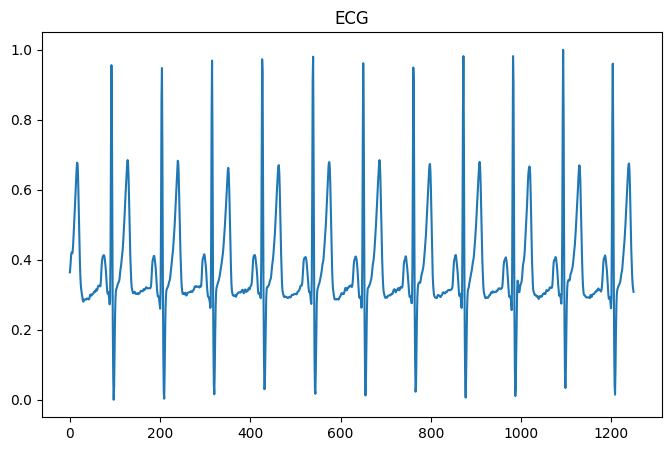

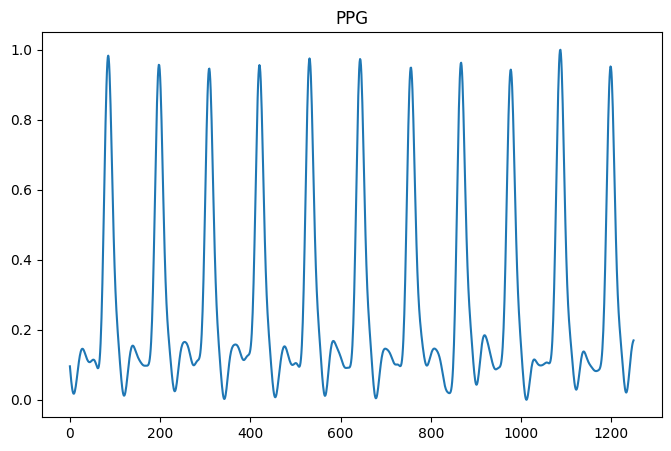

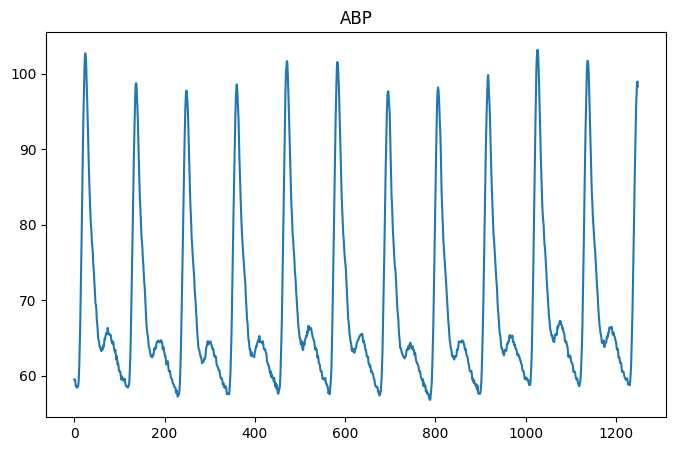

In [5]:
signals = data_df.loc[0]["Signals"]

def plot_signal (title, signal):
    plt.figure(figsize = (8, 5))
    plt.plot(signal)
    plt.title(title)
    plt.show()

for i, title in enumerate(["ECG", "PPG", "ABP"]):
    plot_signal(title, signals[i])

In [6]:
data_df.loc[:, "Signals"] = data_df.loc[:, "Signals"].apply(lambda x: x[1])

In [7]:
data_df = data_df.rename(
    columns = {
        "Age": "age",
        "BMI": "bmi",
        "DBP": "dbp",
        "SBP": "sbp",
        "Gender": "gender",
        "Height": "height",
        "Signals": "signal",
        "Subject": "subject",
        "Weight": "weight"
    }
)

In [8]:
data_df = data_df[["gender", "age", "weight", "height", "bmi", "signal", "dbp", "sbp"]]

In [9]:
data_df

,gender,age,weight,height,bmi,signal,dbp,sbp
0,1,26.0,89.05,183.9,26.3,"[0.09558564133507576, 0.08034762507124568, 0.0...",57.966649,99.987120
1,1,26.0,89.05,183.9,26.3,"[0.9297905141750652, 0.9399888619322257, 0.939...",58.320482,100.759058
2,1,26.0,89.05,183.9,26.3,"[0.12351961433660608, 0.12247612139897121, 0.1...",59.022303,102.019124
3,1,26.0,89.05,183.9,26.3,"[0.06187197844682026, 0.04972063498197406, 0.0...",59.802165,102.834648
4,1,26.0,89.05,183.9,26.3,"[0.17820817689407467, 0.17872682753601465, 0.1...",58.068798,100.265742
...,...,...,...,...,...,...,...,...
661,1,51.0,81.60,186.0,23.6,"[0.2612889579209523, 0.24247805817040835, 0.22...",67.354875,158.041383
662,1,51.0,81.60,186.0,23.6,"[0.6524835843199924, 0.6342669050545015, 0.618...",66.764646,154.649431
663,1,51.0,81.60,186.0,23.6,"[0.203036472140417, 0.18776552828829857, 0.172...",67.429088,160.446045
664,1,51.0,81.60,186.0,23.6,"[1.0, 0.99346053784738, 0.982223957031127, 0.9...",69.336335,165.430557


## Visualization of Data

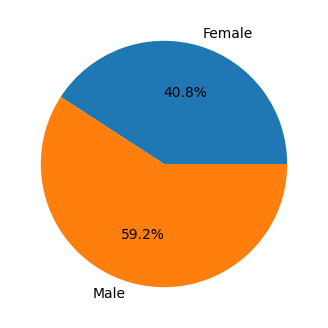

In [10]:
plt.figure(figsize = (4, 4))
data_df["gender"].value_counts().sort_index().plot(
    kind = "pie",
    rot = 0,
    autopct = "%1.1f%%",
    labels = ["Female", "Male"],
    ylabel = ""
)
plt.show()

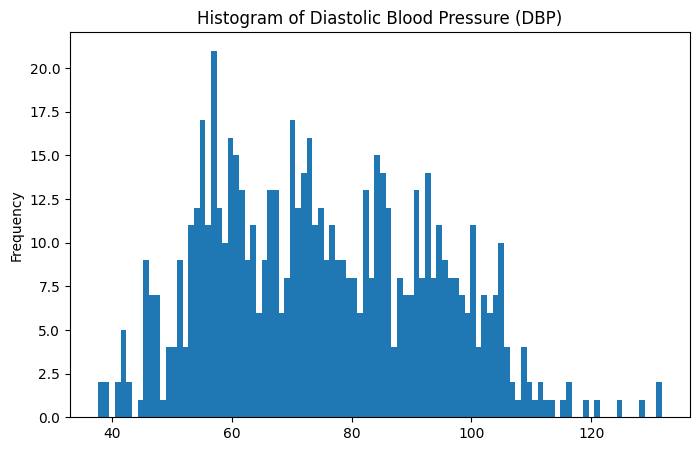

In [11]:
plt.figure(figsize = (8, 5))
data_df["dbp"].plot.hist(bins = 100)
plt.title("Histogram of Diastolic Blood Pressure (DBP)")
plt.show()

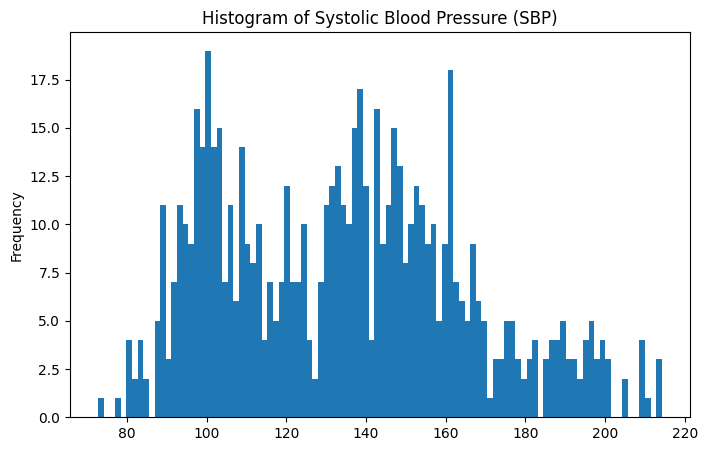

In [12]:
plt.figure(figsize = (8, 5))
data_df["sbp"].plot.hist(bins = 100)
plt.title("Histogram of Systolic Blood Pressure (SBP)")
plt.show()

# Sections Extraction

## General Functions

In [13]:
def scale_signal (signal, mode = "minmax"):
    if mode == "minmax":
        return (np.array(signal) - np.min(signal)) / (np.max(signal) - np.min(signal))
    elif mode == "standard":
        return (np.array(signal) - np.mean(signal)) / np.std(signal)
    else:
        return None

In [14]:
def gradient (signal, mode = "standard"):
    grad = np.gradient(signal)
    if mode:
        grad = scale_signal(grad, mode)
    return grad

In [15]:
def scipy_find_peaks (signal):
    candidates, _ = scipy.signal.find_peaks(signal)
    return np.array(candidates)

In [16]:
def crossing_value (array, value):
    indices = set()
    for i in range(len(array) - 1):
        if array[i] == value:
            indices.add(i)
        elif (array[i] - value) * (array[i + 1] - value) < 0:
            indices.add(i + 0.5)
    return np.array(sorted(list(indices)))

## Triggering

In [17]:
def extract_sections (signal, plot = False):
    # Derivatives

    g1 = gradient(signal)
    g2 = gradient(g1)

    # Peaks and Troughs

    peaks = find_peaks(signal)
    troughs = find_peaks(np.negative(signal))

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 8))

        ax1.plot(signal)
        ax1.plot(peaks, signal[peaks], "o", color = "red", label = "Peak")
        ax1.plot(troughs, signal[troughs], "o", color = "purple", label = "Trough")
        ax1.legend()
        ax1.grid()
        ax1.set_ylabel("PPG Signal")
        
        ax2.plot(g1)
        ax2.grid()
        ax2.set_ylabel("First Derivative")
        
        ax3.plot(g2)
        ax3.grid()
        ax3.set_ylabel("Second Derivative")

        plt.savefig("peaks.png", dpi = 300)
        plt.show()

    # Ascending and Descending Sections and Detection of Foots
    
    sections = [
        {} for _ in range(len(troughs) - 1)
    ]
    
    for i in range(1, len(troughs)):
        ta, tb = troughs[i - 1], troughs[i]
            
        in_peaks = [y for y in peaks if ta < y < tb]
    
        if len(in_peaks) != 1:
            continue
        
        sections[i - 1] = {
            "foots": [
                troughs[i - 1],
                troughs[i]
            ],
            "systolic_peak": in_peaks[0]
        }

    # Detection of Maximum Slope Points
    
    for i, section in enumerate(sections):
        if not section:
            continue
        a, b = section["foots"][0], section["systolic_peak"]
        sections[i]["max_slope_point"] = np.argmax(g1[a:b]) + a


    # Detection of Diastolic Peaks

    for i, section in enumerate(sections):
        if not section:
            continue

        a, b = section["systolic_peak"], section["foots"][1]

        diastolic_peak = -1
    
        candidates = scipy_find_peaks(signal[a:b]) + a
    
        for candidate in candidates.tolist():
            if candidate > a + 25 and candidate < b - 25 and g2[candidate] < 0:
                diastolic_peak = candidate
                break
    
        if diastolic_peak == -1:
            g2_mins = find_peaks(np.negative(g2[a:b])) + a
            g2_mins = [peak for peak in g2_mins if a + 25 < peak < b - 25]
            if g2_mins:
                diastolic_peak = g2_mins[int((len(g2_mins) - 1) / 2)]
            else:
                diastolic_peak = int(a + (b - a) * 0.75)

        sections[i]["diastolic_peak"] = diastolic_peak
    

    # Detection of Dicrotic Notchs

    for i, section in enumerate(sections):
        if not section:
            continue

        a, b = section["systolic_peak"], section["foots"][1]
        s, e = section["systolic_peak"], section["diastolic_peak"]
    
        slope = (signal[e] - signal[s]) / (e - s)
        h = signal[s] - slope * s
        xs = np.arange(s, e)
        line = slope * xs + h
    
        notch = np.argmin(signal[s:e] - line) + s
        
        candidates = scipy_find_peaks(np.negative(signal[a:b])) + a
    
        for candidate in candidates:
            if notch - 25 < candidate < notch + 25:
                notch = candidate
                break

        sections[i]["notch_point"] = notch if a + 10 < notch < b - 10 else (s + e) // 2

    # Detection of Inflection Point

    for i, section in enumerate(sections):
        if not section:
            continue

        a, b = section["notch_point"], section["diastolic_peak"]
        
        candidates = find_peaks_original(g1)
        candidates = [candidate for candidate in candidates if a + 5 < candidate < b - 5]
        
        if candidates:
            section["inflection_point"] = candidates[int((len(candidates) - 1) / 2)]
        else:
            section["inflection_point"] = (a + b) // 2
    
    # Plot

    if plot:
        ascending_sections = [(section["foots"][0], section["systolic_peak"]) for section in sections if section]
        descending_sections = [(section["systolic_peak"], section["foots"][1]) for section in sections if section]
        systolic_peaks = [section["systolic_peak"] for section in sections if section]
        foots = []
        for section in sections:
            if section:
                foots.extend(section["foots"])
        foots = list(set(foots))
        max_slope_points = [section["max_slope_point"] for section in sections if section]
        diastolic_peaks = [section["diastolic_peak"] for section in sections if section]
        notch_points = [section["notch_point"] for section in sections if section]
        inflection_points = [section["inflection_point"] for section in sections if section]
        
        plt.figure(figsize = (15, 7))
        plt.plot(signal)
        for a, b in ascending_sections:
            plt.plot(np.arange(a, b), signal[a:b], linestyle = "-", linewidth = 2, color = "black")
        for a, b in descending_sections:
            x = np.arange(a, b)
            plt.plot(np.arange(a, b), signal[a:b], linestyle = "-", linewidth = 2, color = "green")
        plt.plot(systolic_peaks, signal[systolic_peaks], "o", color = "red", label = "Systolic Peak")
        plt.plot(foots, signal[foots], "o", color = "purple", label = "Foot")
        plt.plot(max_slope_points, signal[max_slope_points], "o", color = "blue", label = "Maximum Slope Point")
        plt.plot(diastolic_peaks, signal[diastolic_peaks], "o", color = "orange", label = "Diastolic Peak")
        plt.plot(notch_points, signal[notch_points], "o", color = "darkred", label = "Dicrotic Notch")
        plt.plot(inflection_points, signal[inflection_points], "s", color = "darkgreen", label = "Inflection Point")
        plt.title("Ascending and Descending Sections and Key Points")
        plt.legend()
        plt.grid()

        plt.savefig("key_points.png", dpi = 300)
        plt.show()

    if plot:
        section_df = pd.DataFrame(sections)
        display(HTML(section_df.to_html()))

    return sections

## Test

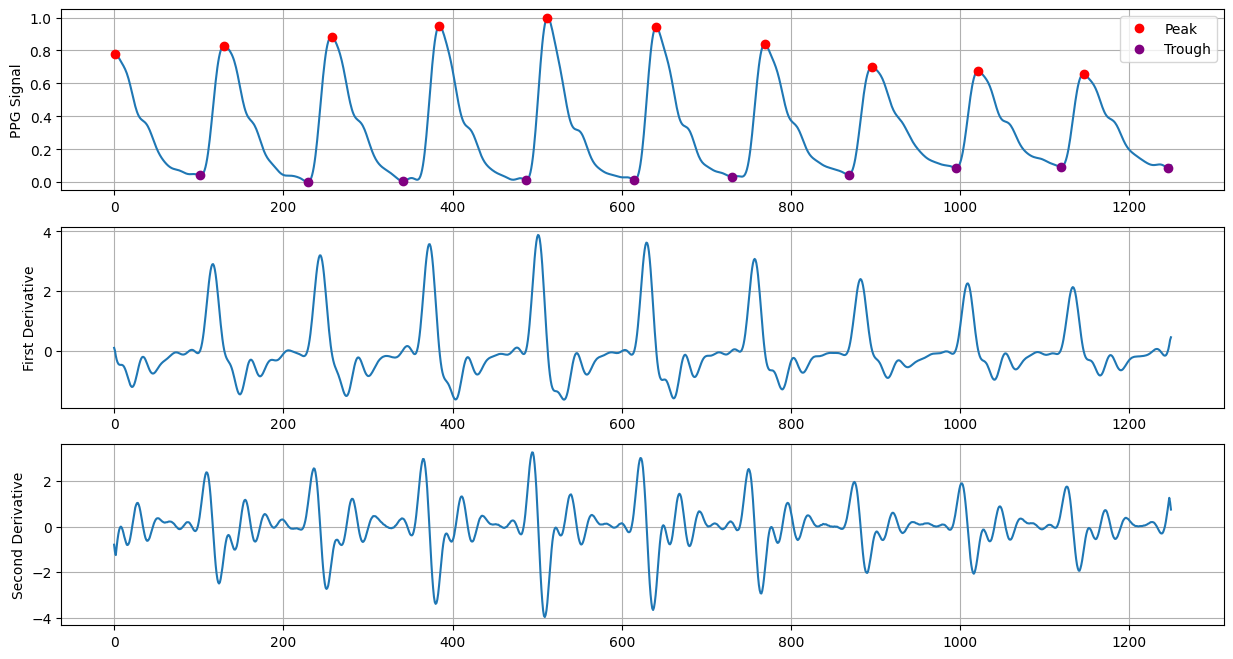

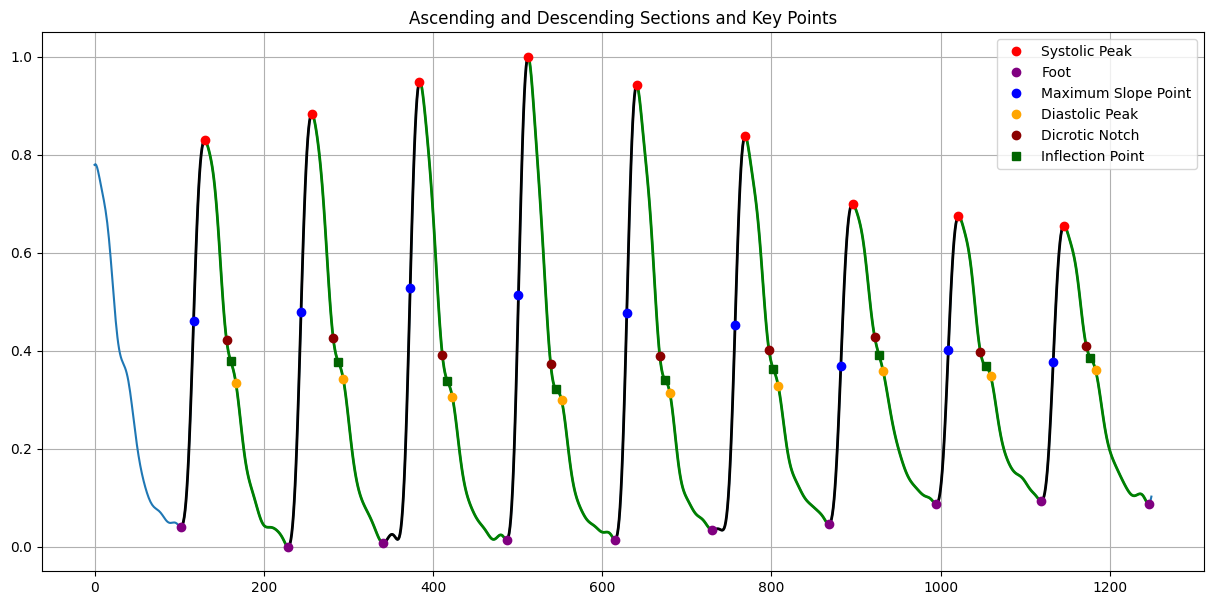

,foots,systolic_peak,max_slope_point,diastolic_peak,notch_point,inflection_point
0,"[102, 229]",130,117,167,156,161
1,"[229, 341]",257,244,294,282,288
2,"[341, 487]",384,373,423,411,417
3,"[487, 615]",512,501,552,539,545
4,"[615, 730]",641,629,680,668,674
5,"[730, 868]",769,757,808,797,802
6,"[868, 995]",896,882,932,922,927
7,"[995, 1119]",1021,1009,1059,1047,1053
8,"[1119, 1246]",1146,1133,1183,1172,1177


In [18]:
row = data_df.loc[63]
sections = extract_sections(row["signal"], plot = True)

In [19]:
sections_bank = []
for i in tqdm(range(data_df.shape[0])):
    sections_bank.append(
        extract_sections(
            data_df.loc[i]["signal"],
            plot = False
        )
    )

100%|█████████████████████████████████████████| 666/666 [00:27<00:00, 24.22it/s]


# Feature Extraction

## General Functions

In [20]:
def arc_length (signal):
    return scipy.integrate.simpson(
        np.sqrt(1 + gradient(signal, mode = None) ** 2)
    )

In [21]:
def extract_features_from_section (section, signal, plot = False):
    features = {}

    a = section["foots"][0]
    b = section["max_slope_point"]
    c = section["systolic_peak"]
    d = section["notch_point"]
    e = section["foots"][1]
    
    f = section["inflection_point"]
    g = section["diastolic_peak"]

    if b - a:
        features["s1"] = (e - a) * (signal[b] - signal[a]) / (b - a)
    if c - b:
        features["s2"] = (e - a) * (signal[c] - signal[b]) / (c - b)
    if d - c:
        features["s3"] = (e - a) * (signal[d] - signal[c]) / (d - c)
    if f - d:
        features["s4"] = (e - a) * (signal[f] - signal[d]) / (f - d)
    if g - f:
        features["s5"] = (e - a) * (signal[g] - signal[f]) / (g - f)
    if e - g:
        features["s6"] = (e - a) * (signal[e] - signal[g]) / (e - g)
    
    features["L_dia"] = arc_length(signal[d:e])
    features["L_sys"] = arc_length(signal[a:c])
    features["L_dic"] = arc_length(signal[c:d])

    g1 = gradient(signal, mode = None) # ?
    g2 = gradient(g1, mode = None) # ?

    features["L_dia_g1"] = arc_length(g1[d:e])
    features["L_sys_g1"] = arc_length(g1[a:c])
    features["L_dic_g1"] = arc_length(g1[c:d])

    features["L_dia_g2"] = arc_length(g2[d:e])
    features["L_sys_g2"] = arc_length(g2[a:c])
    features["L_dic_g2"] = arc_length(g2[c:d])

    for w in [10, 25, 33, 50, 66, 75]:
        x = signal[c] - signal[a]
        candidates = crossing_value(signal, signal[a] + (w / 100) * x)
        candidates = [candidate for candidate in candidates if a < candidate < e]
        if len(candidates) >= 2:
            features[f"width{w}"] = candidates[-1] - candidates[0]

    features["p_max_slope_point"] = signal[section["max_slope_point"]] - signal[a]
    features["p_systolic_peak"] = signal[section["systolic_peak"]] - signal[a]
    features["p_notch_point"] = signal[section["notch_point"]] - signal[e]
    features["p_inflection_point"] = signal[section["inflection_point"]] - signal[e]
    features["p_diastolic_peak"] = signal[section["diastolic_peak"]] - signal[e]

    # features["ras"] = features["p_diastolic_peak"] / features["p_systolic_peak"]

    # features["ipa"] = scipy.integrate.simpson(signal[f:e] - signal[f - a:e - a]) / scipy.integrate.simpson(signal[a:f] - signal[:f - a])
    # features["ri"] = features["p_inflection_point"] / features["p_systolic_peak"]
    # I_ac = np.max(signal[a:e]) - np.min(signal[a:e])
    # features["mnpv"] = I_ac / (I_ac + np.mean(signal[a:e]))
    # features["stiffness"] = 1 / (section["diastolic_peak"] - section["systolic_peak"])

    return features

In [22]:
def extract_features_from_signal (sections, signal, plot = False):
    s_features = [
        extract_features_from_section(section, signal, plot = plot)
        for section in sections if section
    ]

    if plot:
        s_features_df = pd.DataFrame(s_features)
        display(HTML(s_features_df.to_html()))

    features = {}

    f_arrays = {}

    for s_feature in s_features:
        for name, value in s_feature.items():
            if name not in f_arrays:
                f_arrays[name] = []
            f_arrays[name].append(value)

    for name, array in f_arrays.items():
        features[f"mean_{name}"] = np.mean(array)
        features[f"std_{name}"] = np.std(array)

    points = {
        "diastolic_peak": "dia",
        "systolic_peak": "sys",
        "notch_point": "dic"
    }

    for point in points.keys():
        array = np.array(
            [
                sections[i + 1][point] - sections[i][point]
                for i in range(len(sections) - 1) if sections[i + 1] and sections[i]
            ]
        )

        label = points[point]
        features[f"mean_{label}_time"] = np.mean(array)
        features[f"std_{label}_time"] = np.std(array)

    
    features["mean"] = np.mean(signal)
    features["median"] = np.median(signal)
    features["std"] = np.std(signal)
    features["p25th"] = np.percentile(signal, 25)
    features["p75th"] = np.percentile(signal, 75)
    features["mad"] = scipy.stats.median_abs_deviation(signal)
    features["iqr"] = features["p75th"] - features["p25th"]
    features["skewness"] = np.mean((signal - features["mean"]) ** 3) / (features["std"] ** 3)
    features["kurtosis"] = np.mean((signal - features["mean"]) ** 4) / (features["std"] ** 4) - 3
    features["shannons_entropy"] = scipy.stats.entropy(signal, base = 2)
    features["spectral_entropy"] = features["shannons_entropy"] / np.log2(signal.shape[0])

    # for key, value in features.items():
    #     features[key] = np.log(value)

    ft = np.abs(scipy.fft.fft(signal))
    

    if plot:
        for key, value in features.items():
            print(key, value, sep = "\t")
    
    return features

In [23]:
def extract_features_from_row (row, sections, plot = True):
    features = extract_features_from_signal(sections, row["signal"], plot = plot)
    # Merge with demographic features!
    return features

## Trigerring

In [24]:
i = 85
row = data_df.loc[i]
features = extract_features_from_row(row, sections_bank[i], plot = True)
print("SBP", row["sbp"], sep = "\t")
print("DBP", row["dbp"], sep = "\t")

,s1,s2,s3,s4,s5,s6,L_dia,L_sys,L_dic,L_dia_g1,L_sys_g1,L_dic_g1,L_dia_g2,L_sys_g2,L_dic_g2,width10,width25,width33,width50,width66,width75,p_max_slope_point,p_systolic_peak,p_notch_point,p_inflection_point,p_diastolic_peak
0,2.185401,2.287832,-1.546375,0.086064,-0.012320,-0.313599,24.000135,22.011550,31.007498,24.000004,22.000210,31.000082,24.000001,22.000005,31.000002,42.0,34.0,31.0,25.0,18.0,15.0,0.327810,0.642387,0.054191,0.059570,0.058800
1,2.034594,2.076126,-1.371506,0.165696,-0.466862,-0.675933,26.000741,24.010620,28.005028,26.000017,24.000173,28.000059,26.000001,24.000004,28.000001,65.0,40.0,35.0,27.0,21.0,18.0,0.351658,0.633601,0.144900,0.157174,0.116828
2,1.951851,2.458000,-1.852192,-0.686095,-0.274142,-0.187013,33.000464,25.012027,22.006095,33.000010,25.000189,22.000063,33.000000,25.000005,22.000002,58.0,38.0,33.0,27.0,20.0,17.0,0.352744,0.678503,0.141222,0.066827,0.033797
3,1.716946,2.192225,-1.404566,0.103338,-0.098429,-0.244002,24.000092,24.009708,29.005698,24.000004,24.000156,29.000070,24.000000,24.000005,29.000002,63.0,36.0,33.0,25.0,20.0,17.0,0.300465,0.601896,0.043624,0.050083,0.042700
4,1.916967,2.614806,-2.196515,-0.524925,-0.440023,-0.397145,35.000540,27.011781,25.008432,35.000016,27.000173,25.000070,35.000001,27.000005,25.000001,44.0,36.0,33.0,26.0,21.0,17.0,0.362094,0.681681,0.177820,0.119495,0.070604
5,2.300457,2.859082,-2.030573,-0.995201,-0.314517,-0.025906,25.000946,21.021402,17.009329,25.000014,21.000421,17.000195,25.000000,21.000016,17.000008,NaN,35.0,30.0,23.0,17.0,14.0,0.453120,0.842995,0.147992,0.042441,0.004318
6,1.404623,2.566382,-2.258123,-1.901006,-1.895293,-1.052189,26.005078,37.014222,18.007075,26.000023,37.000226,18.000078,26.000001,37.000007,18.000003,48.0,37.0,34.0,26.0,20.0,16.0,0.468208,0.773729,0.489234,0.330817,0.150313
7,1.671927,4.372188,-2.996452,-0.740474,-0.510051,-0.554184,38.000818,40.024570,17.009483,38.000014,40.000385,17.000210,38.000001,40.000013,17.000008,NaN,62.0,46.0,25.0,19.0,15.0,0.528875,0.975016,0.237950,0.147279,0.084824
8,2.605639,2.871393,-2.146648,-0.633581,-0.312279,-0.309866,34.000613,21.016192,23.008900,34.000016,21.000320,23.000097,34.000001,21.000010,23.000004,43.0,34.0,30.0,24.0,19.0,15.0,0.386021,0.740514,0.174156,0.095936,0.057383
9,2.312902,2.604216,-1.838287,-0.579227,-0.291828,-0.331131,35.000500,24.014217,22.005824,35.000011,24.000238,22.000060,35.000001,24.000007,22.000002,72.0,42.0,35.0,27.0,21.0,17.0,0.385484,0.726512,0.166302,0.097346,0.059131


mean_s1	2.0214645864941647
std_s1	0.2927807906850328
mean_s2	2.6049010658162195
std_s2	0.5387300071251678
mean_s3	-1.8918709889079062
std_s3	0.4065445155952929
mean_s4	-0.5691245550894944
std_s4	0.49496308737893624
mean_s5	-0.42474791621268454
std_s5	0.42677342062254864
mean_s6	-0.35826160372940047
std_s6	0.24607090668880843
mean_L_dia	31.143686714616567
std_L_dia	4.733419744157332
mean_L_sys	25.72793650913153
std_L_sys	5.45865387337587
mean_L_dic	23.2924962591738
std_L_dic	4.0424242526823955
mean_L_dia_g1	31.142868729397183
std_L_dia_g1	4.73372636842441
mean_L_sys_g1	25.714515247876744
std_L_sys_g1	5.456713165535845
mean_L_dic_g1	23.28579934031151
std_L_dic_g1	4.043105480507365
mean_L_dia_g2	31.142857781539497
std_L_dia_g2	4.733726264326408
mean_L_sys_g2	25.714292617454515
std_L_sys_g2	5.456694870374629
mean_L_dic_g2	23.28571703588508
std_L_dic_g2	4.04313328009825
mean_width10	55.333333333333336
std_width10	9.348202441586771
mean_width25	39.214285714285715
std_width25	6.73136126573191

In [25]:
for i in tqdm(range(data_df.shape[0])):
    features = extract_features_from_row(data_df.loc[i], sections_bank[i], plot = False)
    for key, value in features.items():
        data_df.loc[i, key] = value

100%|█████████████████████████████████████████| 666/666 [00:30<00:00, 21.82it/s]


# Constructing Features Matrix

In [26]:
features_df = data_df.drop(columns = ["signal"])

## Correlation Matrix

In [27]:
corr_mat = features_df.corr()
corr_mat

,gender,age,weight,height,bmi,dbp,sbp,mean_s1,std_s1,mean_s2,...,median,std,p25th,p75th,mad,iqr,skewness,kurtosis,shannons_entropy,spectral_entropy
gender,1.000000,-0.049948,0.459650,0.683167,0.077687,-0.076336,-0.140425,0.055614,0.091851,0.145025,...,-0.137108,-0.037735,-0.058062,-0.198393,-0.176114,-0.180527,0.190546,0.148905,-0.074916,-0.074916
age,-0.049948,1.000000,-0.210240,-0.375616,0.044041,0.008362,0.140202,-0.006788,-0.016318,-0.159309,...,0.116338,0.169820,-0.052344,0.236245,0.239396,0.283493,-0.218352,-0.257569,0.023448,0.023448
weight,0.459650,-0.210240,1.000000,0.670645,0.801390,-0.008577,-0.089336,-0.047255,0.116574,0.099274,...,-0.149668,-0.129192,-0.005023,-0.241587,-0.238167,-0.256878,0.209957,0.214715,-0.066035,-0.066035
height,0.683167,-0.375616,0.670645,1.000000,0.101192,-0.062695,-0.125035,0.025294,0.077051,0.151668,...,-0.146502,-0.136110,-0.005128,-0.265350,-0.244226,-0.282364,0.226183,0.221704,-0.048363,-0.048363
bmi,0.077687,0.044041,0.801390,0.101192,1.000000,0.048716,-0.009745,-0.073864,0.097005,-0.004673,...,-0.068379,-0.076887,0.012680,-0.098916,-0.117553,-0.113489,0.084087,0.094913,-0.027658,-0.027658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iqr,-0.180527,0.283493,-0.256878,-0.282364,-0.113489,0.410454,0.493270,0.108158,-0.372958,-0.363271,...,0.265552,0.760531,-0.144026,0.854645,0.747580,1.000000,-0.729198,-0.882578,-0.064886,-0.064886
skewness,0.190546,-0.218352,0.209957,0.226183,0.084087,-0.585087,-0.635558,-0.041459,0.302223,0.714361,...,-0.785053,-0.165727,-0.495400,-0.938238,-0.844728,-0.729198,1.000000,0.929075,-0.544593,-0.544593
kurtosis,0.148905,-0.257569,0.214715,0.221704,0.094913,-0.545229,-0.602930,-0.039170,0.376154,0.617224,...,-0.555784,-0.436135,-0.248002,-0.951108,-0.786751,-0.882578,0.929075,1.000000,-0.307240,-0.307240
shannons_entropy,-0.074916,0.023448,-0.066035,-0.048363,-0.027658,0.350995,0.363069,-0.002415,-0.010255,-0.620392,...,0.847309,-0.621481,0.920148,0.422429,0.350886,-0.064886,-0.544593,-0.307240,1.000000,1.000000


In [28]:
print(corr_mat["sbp"].sort_values(ascending = False).to_string())

sbp                        1.000000
dbp                        0.861886
p75th                      0.636813
mean                       0.579884
iqr                        0.493270
mad                        0.489220
mean_s3                    0.472411
median                     0.460131
spectral_entropy           0.363069
shannons_entropy           0.363069
p25th                      0.339188
mean_width75               0.263475
mean_width66               0.252288
mean_width50               0.193862
age                        0.140202
std_s6                     0.129017
std_p_systolic_peak        0.125691
std                        0.115206
std_p_inflection_point     0.113914
mean_width33               0.100741
std_p_max_slope_point      0.090276
std_p_diastolic_peak       0.084405
std_p_notch_point          0.059486
std_width75                0.057012
mean_width25               0.055578
mean_p_notch_point         0.041626
std_width66                0.037107
std_width50                0

In [29]:
print(corr_mat["dbp"].sort_values(ascending = False).to_string())

dbp                        1.000000
sbp                        0.861886
p75th                      0.561320
mean                       0.536197
mad                        0.439643
mean_s3                    0.435220
median                     0.433044
iqr                        0.410454
spectral_entropy           0.350995
shannons_entropy           0.350995
p25th                      0.342130
mean_width75               0.195248
mean_width66               0.192042
mean_width50               0.159775
std_p_systolic_peak        0.148101
std_p_inflection_point     0.124498
std_p_max_slope_point      0.104877
std_s6                     0.093510
std_p_notch_point          0.088681
mean_width33               0.086484
mean_p_notch_point         0.083731
std_p_diastolic_peak       0.080957
std                        0.070352
mean_p_inflection_point    0.061275
bmi                        0.048716
mean_width25               0.047420
std_width75                0.034975
std_width66                0

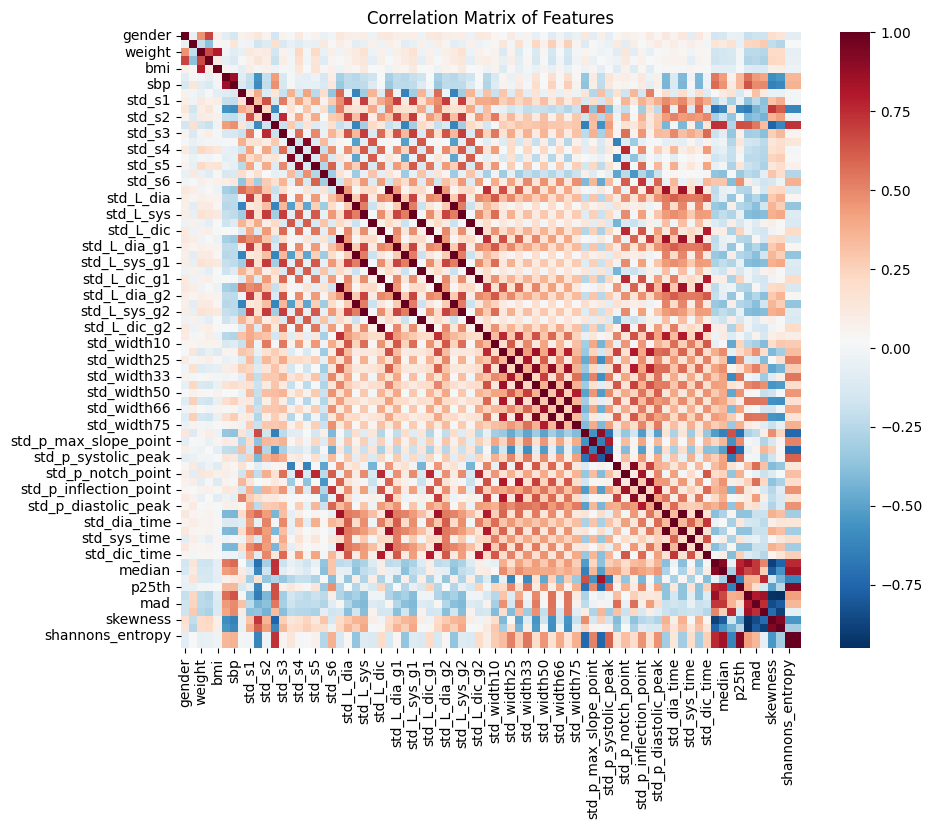

In [30]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr_mat, annot = False, cmap = "RdBu_r")
plt.title("Correlation Matrix of Features")
plt.savefig("correlation_matrix.png", bbox_inches="tight", dpi = 300)
plt.show()

# Feature Selection

In [31]:
fdf = features_df.drop(columns = ["sbp", "dbp"])
features = mrmr.mrmr_regression(
    X = fdf,
    y = features_df["sbp"],
    K = 32
)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 59.54it/s]


In [32]:
features

['p75th',
 'std_p_systolic_peak',
 'skewness',
 'mean_s2',
 'kurtosis',
 'mean',
 'mean_dia_time',
 'iqr',
 'mad',
 'mean_dic_time',
 'mean_s3',
 'mean_sys_time',
 'median',
 'mean_p_max_slope_point',
 'mean_L_dia',
 'mean_L_dia_g2',
 'spectral_entropy',
 'mean_L_dia_g1',
 'shannons_entropy',
 'p25th',
 'mean_width10',
 'mean_L_sys',
 'mean_width75',
 'std_L_dia_g2',
 'mean_L_sys_g1',
 'mean_L_sys_g2',
 'std_L_dia_g1',
 'mean_width66',
 'mean_p_systolic_peak',
 'age',
 'gender',
 'std_L_dia']

## Exporting Feature Matrix

In [33]:
last_cols = ["dbp", "sbp"]
features_df = features_df.reindex(
    columns = [col for col in features_df.columns if col not in last_cols] + last_cols
)

In [34]:
features_df["dbp"] = pd.to_numeric(features_df["dbp"])
features_df["sbp"] = pd.to_numeric(features_df["sbp"])

In [35]:
features_df

,gender,age,weight,height,bmi,mean_s1,std_s1,mean_s2,std_s2,mean_s3,...,p25th,p75th,mad,iqr,skewness,kurtosis,shannons_entropy,spectral_entropy,dbp,sbp
0,1,26.0,89.05,183.9,26.3,1.076526,0.313683,4.706773,0.841947,-4.404761,...,0.098630,0.327531,0.050572,0.228901,1.453969,0.735555,9.639000,0.936943,57.966649,99.987120
1,1,26.0,89.05,183.9,26.3,0.920225,0.044189,4.833590,0.231575,-4.746126,...,0.108269,0.346271,0.051605,0.238002,1.406200,0.579485,9.675207,0.940462,58.320482,100.759058
2,1,26.0,89.05,183.9,26.3,0.979187,0.199704,4.698177,1.004998,-4.390863,...,0.097341,0.335279,0.057346,0.237938,1.431511,0.654294,9.677071,0.940644,59.022303,102.019124
3,1,26.0,89.05,183.9,26.3,0.901581,0.061005,4.691357,0.207623,-4.630416,...,0.084101,0.309944,0.056907,0.225843,1.479525,0.790173,9.609118,0.934038,59.802165,102.834648
4,1,26.0,89.05,183.9,26.3,0.917123,0.069391,4.727339,0.270923,-4.560423,...,0.112514,0.322766,0.052357,0.210252,1.471332,0.803923,9.706574,0.943511,58.068798,100.265742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,1,51.0,81.60,186.0,23.6,2.684659,0.267099,2.803873,0.372967,-1.625934,...,0.181493,0.691405,0.196568,0.509912,0.412075,-1.291309,9.939783,0.966180,67.354875,158.041383
662,1,51.0,81.60,186.0,23.6,2.365345,0.443888,2.488603,0.302697,-1.450353,...,0.235724,0.657994,0.183673,0.422270,0.306945,-1.070424,10.054841,0.977364,66.764646,154.649431
663,1,51.0,81.60,186.0,23.6,2.512441,0.316811,2.609838,0.314200,-1.512684,...,0.187967,0.617998,0.176876,0.430031,0.440376,-1.091376,9.987454,0.970814,67.429088,160.446045
664,1,51.0,81.60,186.0,23.6,2.824505,0.326535,3.026811,0.345313,-1.568525,...,0.235560,0.684284,0.194875,0.448724,0.353602,-1.170171,10.011257,0.973128,69.336335,165.430557


In [36]:
pd.to_pickle(features_df, "dataset/features.pickle")

In [38]:
features_df.to_numpy()[:, -1].dtype

dtype('float64')

In [39]:
with open("dataset/features.json", "w") as handler:
    json.dump(
        [
            list(features_df.columns).index(x) for x in features
        ],
        handler
    )